In [102]:
#import libraries
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Constructing Data Frame

Data Frame differs from the one in `employee_groupings.ipynb` because this one covers years from 2021-2025.  
Years 2021-2025 can be used for turnover calculations, 2025 will be used for reason for turnover

In [103]:
#Generate the intermediate df (without the age bracket and tenure)

#import file
headcount = 'Forvis Mazars Data Request\Headcount - Employee Dates and Status - 2021 to 2025 - Duplicates Dropped.xlsx'
headcount_df = pd.read_excel(headcount)

#helper functions
def age_in_years(birth_date, as_of):
    if pd.isna(birth_date):
        return np.nan
    return relativedelta(as_of, birth_date).years

def tenure_years_months(start_date, end_date):
    if pd.isna(start_date) or pd.isna(end_date) or end_date < start_date:
        return None
    rd = relativedelta(end_date, start_date)
    return f"{rd.years} years {rd.months} months"

#process data for 2022-2025, excluding 2021 because of covid
years_to_process = [2022, 2023, 2024, 2025]
all_year_data = []

for year_value in years_to_process:
    as_of_date = pd.Timestamp(f"{year_value}-12-31")
    year_start_date = pd.Timestamp(f"{year_value}-01-01")
    
    df = headcount_df.copy()
    
    #rename the columns
    df = df.rename(columns={
        "Payroll Name": "employee_name",
        "Hire Date": "hire_date",
        "Termination Date": "termination_date",
        "Birth Year": "birth_date"
    })
    
    #convert dates
    df["hire_date"] = pd.to_datetime(df["hire_date"], errors="coerce")
    df["termination_date"] = pd.to_datetime(df["termination_date"], errors="coerce")
    df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")
    
    #filter dataset for this year, include employees: who were hired on or before the year-end date and either had no termination or terminated on or after the year start date
    df = df.loc[
        (df["hire_date"] <= as_of_date) &
        (df["termination_date"].isna() | (df["termination_date"] >= year_start_date))
    ].copy()
    df.reset_index(drop=True, inplace=True)
    
    #calculate tenure end date for each employee: as of the year-end date or termination  date (whichever is earlier)
    tenure_end = df["termination_date"].where(
        df["termination_date"].notna() & (df["termination_date"] <= as_of_date),
        as_of_date
    )
    
    #conversions - age and tenure calculated as of the year-end date
    df["age"] = df["birth_date"].apply(lambda d: age_in_years(d, as_of_date)).astype("Int64")
    df["tenure"] = [tenure_years_months(hire, end) for hire, end in zip(df["hire_date"], tenure_end)]
    df["year"] = year_value
    
    #turnover
    df["turnover"] = np.where(
        df["termination_date"].notna() & (df["termination_date"] <= as_of_date), 
        "Yes", 
        "No"
    )
    
    #select output columns
    year_df = df[[
        "employee_name",
        "age",
        "tenure",
        "year",
        "turnover"
    ]].copy()
    
    all_year_data.append(year_df)

#combine all years into single dataframe
output_df = pd.concat(all_year_data, ignore_index=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
output_df.head(10)

,employee_name,age,tenure,year,turnover
0,"Abreu, Heny",59,0 years 2 months,2022,No
1,"Abshire, John R",54,10 years 6 months,2022,No
2,"Agostini, Carlos I",53,17 years 9 months,2022,No
3,"Ahorrio, Jose L",42,1 years 9 months,2022,No
4,"Algarin, Jose A",50,1 years 4 months,2022,No
5,"Alicea, David",62,14 years 0 months,2022,Yes
6,"Allen, Luke E",39,8 years 5 months,2022,No
7,"Allers, Andrew C",38,5 years 11 months,2022,No
8,"Allman, Scott",35,6 years 3 months,2022,No
9,"Altmeyer, Anthony",48,1 years 8 months,2022,No


In [104]:
#add age bracket and tenure bracket columns to output_df
def get_age_bracket(birth_date):
    if pd.isna(birth_date):
        return None
    year = birth_date.year
    if 1928 <= year <= 1945:
        return 'Post War'
    elif 1946 <= year <= 1964:
        return 'Baby Boomers'
    elif 1965 <= year <= 1980:
        return 'Gen X'
    elif 1981 <= year <= 1996:
        return 'Millennials'
    elif 1997 <= year <= 2012:
        return 'Gen Z'
    else:
        return None

def get_tenure_bracket(tenure):
    if pd.isna(tenure) or tenure is None:
        return None
    try:
        years = int(str(tenure).split(' ')[0])
    except:
        return None
    if years < 2:
        return '<2 years'
    elif 2 <= years < 5:
        return '2-5 years'
    elif 5 <= years < 10:
        return '5-10 years'
    elif 10 <= years < 20:
        return '10-20 years'
    elif years >= 20:
        return '20+ years'
    else:
        return None

#temp merge birth_date from headcount_df to calculate age_bracket
output_df = output_df.merge(
    headcount_df[['Payroll Name', 'Birth Year']].rename(columns={'Birth Year': 'birth_date'}),
    left_on='employee_name',
    right_on='Payroll Name',
    how='left'
)
output_df['birth_date'] = pd.to_datetime(output_df['birth_date'], errors='coerce')
output_df.drop(columns=['Payroll Name'], inplace=True)

#apply bracket functions
output_df['age_bracket'] = output_df['birth_date'].apply(get_age_bracket)
output_df['tenure_bracket'] = output_df['tenure'].apply(get_tenure_bracket)

#drop temp col
output_df.drop(columns=['birth_date'], inplace=True)

output_df.head(10)

,employee_name,age,tenure,year,turnover,age_bracket,tenure_bracket
0,"Abreu, Heny",59,0 years 2 months,2022,No,Baby Boomers,<2 years
1,"Abshire, John R",54,10 years 6 months,2022,No,Gen X,10-20 years
2,"Agostini, Carlos I",53,17 years 9 months,2022,No,Gen X,10-20 years
3,"Ahorrio, Jose L",42,1 years 9 months,2022,No,Gen X,<2 years
4,"Algarin, Jose A",50,1 years 4 months,2022,No,Gen X,<2 years
5,"Alicea, David",62,14 years 0 months,2022,Yes,Baby Boomers,10-20 years
6,"Allen, Luke E",39,8 years 5 months,2022,No,Millennials,5-10 years
7,"Allers, Andrew C",38,5 years 11 months,2022,No,Millennials,5-10 years
8,"Allman, Scott",35,6 years 3 months,2022,No,Millennials,5-10 years
9,"Altmeyer, Anthony",48,1 years 8 months,2022,No,Gen X,<2 years


In [105]:
#import and clean the termination report

#import file
termination_file = 'Forvis Mazars Data Request/termination report & payouts 2025.xlsx'
df_termination = pd.read_excel(termination_file)

import re
def clean_reason(reason):
    if pd.isnull(reason):
        return reason
    return re.sub(r'^[A-Za-z0-9]+\s*-\s*', '', str(reason)).strip()

#update the reason column
if 'REASON' in df_termination.columns:
    df_termination['REASON_CLEAN'] = df_termination['REASON'].apply(clean_reason)

    #mapping for cleaned responses to grouped
    def group_reason(reason):
        if pd.isnull(reason):
            return 'Terminated'
        r = reason.strip().lower()
        if r == 'resignation':
            return 'Resignation'
        elif r == 'retired' or r == 'retirement':
            return 'Retired'
        elif r == 'deceased':
            return 'Deceased'
        else:
            return 'Terminated'

    df_termination['REASON_GROUPED'] = df_termination['REASON_CLEAN'].apply(group_reason)
    reason_counts = df_termination['REASON_GROUPED'].value_counts(dropna=False)
else:
    print('REASON column not found in the file.')

df_termination.head(5)

,NAME,TERMINATION TYPE,PAYOUT,REASON,EMPLOYEE STATUS,TERMINATION DATE,HOME DEPARTMENT,JOB TITLE,HIRE DATE,REASON_CLEAN,REASON_GROUPED
0,"Acevedo, Joshua",Voluntary,V:34.44 Hours,Q - Resignation,Terminated,10/01/2025,"006040 - Customer Service, Fixed Allocation",STII - Service Technician II,10/30/2023,Resignation,Resignation
1,"Algarin, Jose A",Voluntary,No,Q - Resignation,Terminated,10/28/2025,"001025 - Field Services, Fixed Allocation",UTII - Utility Technician II,08/09/2021,Resignation,Resignation
2,"Ayala, Kevin Alexis",Voluntary,No,Q - Resignation,Terminated,05/30/2025,"001025 - Field Services, Fixed Allocation",UW - Utility Worker,01/21/2025,Resignation,Resignation
3,"Bennett, Robert D",Voluntary,V:41.08,Retired,Terminated,02/14/2025,"N01001 - Water Treatment, NP, Fixed Alloc",TOIII-CL - Treatment Operator III/C Lead,06/07/1993,Retired,Retired
4,"Burgos, William A",Involuntary,No,Z - Performance,Terminated,02/18/2025,"001025 - Field Services, Fixed Allocation",UTI - Utility Technician I,04/04/2022,Performance,Terminated


In [106]:
#merge REASON_GROUPED to Status

#match olumn types
headcount_df['Payroll Name'] = headcount_df['Payroll Name'].astype(str)
df_termination['NAME'] = df_termination['NAME'].astype(str)

#create mapping
reason_map = df_termination.set_index('NAME')['REASON_GROUPED'].to_dict()

#replace status when match
def update_status(row):
    if row['Payroll Name'] in reason_map:
        return reason_map[row['Payroll Name']]
    else:
        return row['Status'] if 'Status' in row else None

headcount_df['Status'] = headcount_df.apply(update_status, axis=1)

In [107]:
#add status to output_df based on turnover and year
if 'Status' in output_df.columns:
    output_df = output_df.drop(columns=['Status'])

output_df = output_df.merge(
    headcount_df[['Payroll Name', 'Status']],
    left_on='employee_name',
    right_on='Payroll Name',
    how='left'
)
output_df.drop(columns=['Payroll Name'], inplace=True)

#set the turnover status for each year
#handle situations where x was employeed in 2022-2024 but left in 2025
def get_status_for_year(row):
    if row['turnover'] == 'Yes':
        #employee terminated this year
        return row['Status'] if pd.notna(row['Status']) else 'Terminated'
    else:
        #employee was active this year
        return 'Active'

output_df['Status'] = output_df.apply(get_status_for_year, axis=1)

output_df.head(10)

,employee_name,age,tenure,year,turnover,age_bracket,tenure_bracket,Status
0,"Abreu, Heny",59,0 years 2 months,2022,No,Baby Boomers,<2 years,Active
1,"Abshire, John R",54,10 years 6 months,2022,No,Gen X,10-20 years,Active
2,"Agostini, Carlos I",53,17 years 9 months,2022,No,Gen X,10-20 years,Active
3,"Ahorrio, Jose L",42,1 years 9 months,2022,No,Gen X,<2 years,Active
4,"Algarin, Jose A",50,1 years 4 months,2022,No,Gen X,<2 years,Active
5,"Alicea, David",62,14 years 0 months,2022,Yes,Baby Boomers,10-20 years,Retired
6,"Allen, Luke E",39,8 years 5 months,2022,No,Millennials,5-10 years,Active
7,"Allers, Andrew C",38,5 years 11 months,2022,No,Millennials,5-10 years,Active
8,"Allman, Scott",35,6 years 3 months,2022,No,Millennials,5-10 years,Active
9,"Altmeyer, Anthony",48,1 years 8 months,2022,No,Gen X,<2 years,Active


In [108]:
#final sort to ensure consistent ordering
output_df = output_df.sort_values(['employee_name', 'year']).reset_index(drop=True)
output_df.head(10)

,employee_name,age,tenure,year,turnover,age_bracket,tenure_bracket,Status
0,"Abarca, Kelvin",41,0 years 4 months,2024,No,Millennials,<2 years,Active
1,"Abarca, Kelvin",42,1 years 4 months,2025,No,Millennials,<2 years,Active
2,"Abbey, Richard W",65,0 years 3 months,2023,No,Baby Boomers,<2 years,Active
3,"Abbey, Richard W",66,1 years 3 months,2024,No,Baby Boomers,<2 years,Active
4,"Abbey, Richard W",67,2 years 3 months,2025,No,Baby Boomers,2-5 years,Active
5,"Abouelkheir, Mohamed",47,0 years 7 months,2024,No,Gen X,<2 years,Active
6,"Abouelkheir, Mohamed",48,1 years 7 months,2025,No,Gen X,<2 years,Active
7,"Abreu, Heny",59,0 years 2 months,2022,No,Baby Boomers,<2 years,Active
8,"Abreu, Heny",60,1 years 2 months,2023,No,Baby Boomers,<2 years,Active
9,"Abreu, Heny",61,1 years 7 months,2024,Yes,Baby Boomers,<2 years,Terminated


In [109]:
#Optional: save output_df to Excel

#output_file = 'output_df_2021_2025.xlsx'
#output_df.to_excel(output_file, index=False)
#print(f"Data saved to: {output_file}")

### Assumptions: 2022-2025 Turnover Rate by Age and Tenure

"Leave" Status does not appear in these visualizations because there is no date provided for when the "Leave" staus was taken by employees

In [110]:
#filter to 2022-2025 only
df_analysis = output_df[output_df['year'].isin([2022, 2023, 2024, 2025])].copy()

#count individuals with status other than Active, grouped by year and status
status_counts = df_analysis[df_analysis['Status'] != 'Active'].groupby(['year', 'Status']).agg(
    count=('employee_name', 'count')
).reset_index()

#pivot to show year as rows and status types as columns
status_pivot = status_counts.pivot(index='year', columns='Status', values='count').fillna(0).astype(int)

#add total column
status_pivot['Total Non-Active'] = status_pivot.sum(axis=1)

print("Count of Non-Active Status by Year:")
print(status_pivot)

Count of Non-Active Status by Year:
Status  Deceased  Resignation  Retired  Terminated  Total Non-Active
year                                                                
2022           0            0        7          40                47
2023           2            0       13          51                66
2024           2            0        6          61                69
2025           3           49        8          21                81


In [111]:
#calculate turnover by age and tenure for each year (2022-2025)
turnover_by_age_tenure = output_df[output_df['year'].isin([2022, 2023, 2024, 2025])].groupby(['year', 'age_bracket', 'tenure_bracket']).agg(
    total_employees=('employee_name', 'count'),
    separations=('turnover', lambda x: (x == 'Yes').sum())
).reset_index()

#calculate separation rate
turnover_by_age_tenure['separation_rate'] = (
    turnover_by_age_tenure['separations'] / turnover_by_age_tenure['total_employees'] * 100
).round(2)

#display the dataframe
turnover_by_age_tenure

,year,age_bracket,tenure_bracket,total_employees,separations,separation_rate
0,2022,Baby Boomers,10-20 years,25,1,4.00
1,2022,Baby Boomers,2-5 years,6,0,0.00
2,2022,Baby Boomers,20+ years,34,3,8.82
3,2022,Baby Boomers,5-10 years,17,1,5.88
4,2022,Baby Boomers,<2 years,15,1,6.67
5,2022,Gen X,10-20 years,67,2,2.99
6,2022,Gen X,2-5 years,27,1,3.70
7,2022,Gen X,20+ years,16,2,12.50
8,2022,Gen X,5-10 years,52,2,3.85
9,2022,Gen X,<2 years,59,8,13.56


In [112]:
#calculate average separation rates across all years (2022-2025) by age bracket and tenure bracket
turnover_avg = turnover_by_age_tenure.groupby(['age_bracket', 'tenure_bracket']).agg(
    avg_total_employees=('total_employees', 'mean'),
    avg_separations=('separations', 'mean'),
    avg_separation_rate=('separation_rate', 'mean')
).reset_index()

#round the averages
turnover_avg['avg_total_employees'] = turnover_avg['avg_total_employees'].round(1)
turnover_avg['avg_separations'] = turnover_avg['avg_separations'].round(1)
turnover_avg['avg_separation_rate'] = turnover_avg['avg_separation_rate'].round(2)

#display the averaged dataframe
turnover_avg

,age_bracket,tenure_bracket,avg_total_employees,avg_separations,avg_separation_rate
0,Baby Boomers,10-20 years,23.2,2.8,11.41
1,Baby Boomers,2-5 years,11.5,1.0,7.08
2,Baby Boomers,20+ years,31.0,3.5,10.98
3,Baby Boomers,5-10 years,11.8,1.8,16.80
4,Baby Boomers,<2 years,12.2,1.5,12.93
5,Gen X,10-20 years,74.5,2.8,3.54
6,Gen X,2-5 years,44.8,4.0,8.36
7,Gen X,20+ years,20.2,1.5,7.90
8,Gen X,5-10 years,41.8,2.5,6.36
9,Gen X,<2 years,63.2,9.5,14.96


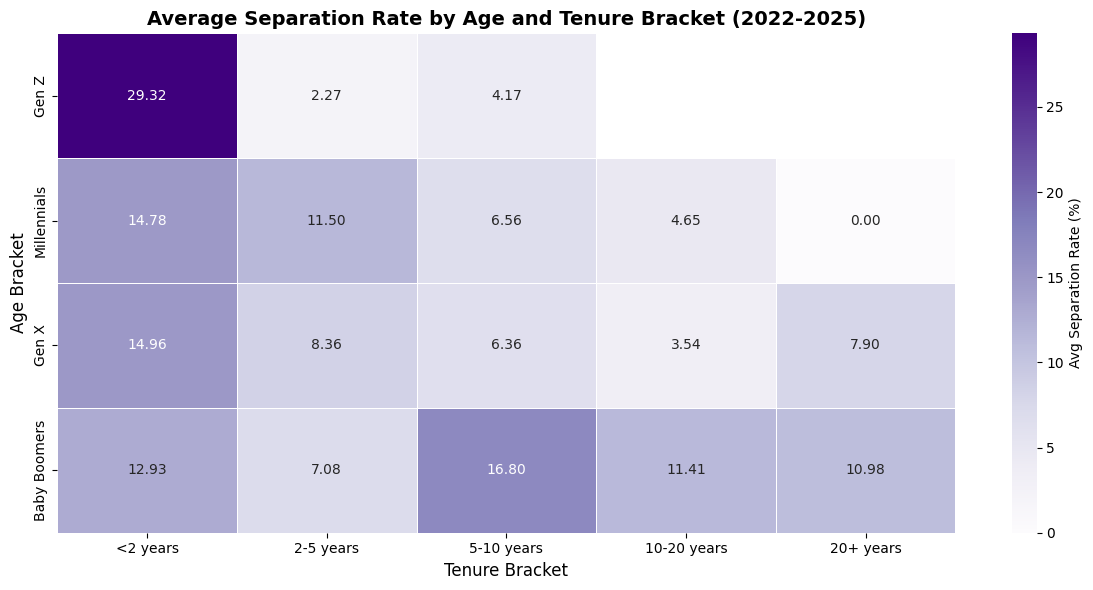

In [ ]:
#Average Separation Rate by Age and Tenure (Heat Map)
plt.figure(figsize=(12, 6))
pivot_heatmap = turnover_avg.pivot(index='age_bracket', columns='tenure_bracket', values='avg_separation_rate')

#order the age brackets and tenure brackets
age_order = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']
tenure_order = ['<2 years', '2-5 years', '5-10 years', '10-20 years', '20+ years']

pivot_heatmap = pivot_heatmap.reindex(index=age_order, columns=tenure_order)

sns.heatmap(pivot_heatmap, annot=True, fmt='.2f', cmap='Purples', 
            cbar_kws={'label': 'Avg Separation Rate (%)'}, linewidths=0.5)
plt.title('Average Separation Rate by Age and Tenure Bracket (2022-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Tenure Bracket', fontsize=12)
plt.ylabel('Age Bracket', fontsize=12)
plt.tight_layout()
plt.show()

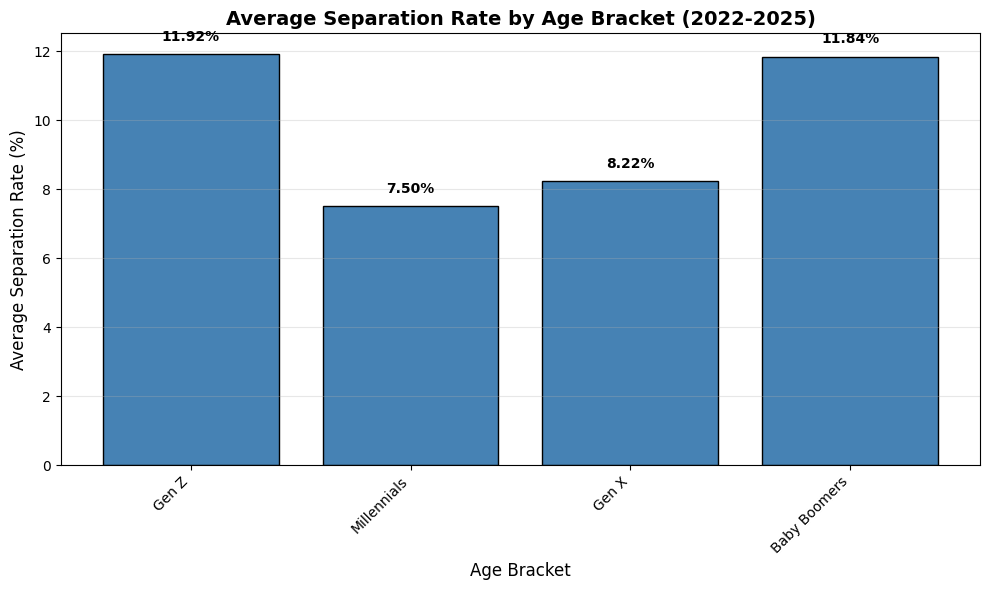

In [ ]:
#Average separation rate by age bracket, aggregated for all tenures
plt.figure(figsize=(10, 6))
age_avg = turnover_avg.groupby('age_bracket')['avg_separation_rate'].mean().reset_index()
age_avg = age_avg.set_index('age_bracket').reindex(age_order).reset_index()

plt.bar(age_avg['age_bracket'], age_avg['avg_separation_rate'], color='steelblue', edgecolor='black')
plt.title('Average Separation Rate by Age Bracket (2022-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Age Bracket', fontsize=12)
plt.ylabel('Average Separation Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(age_avg['avg_separation_rate']):
    plt.text(i, v + 0.3, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

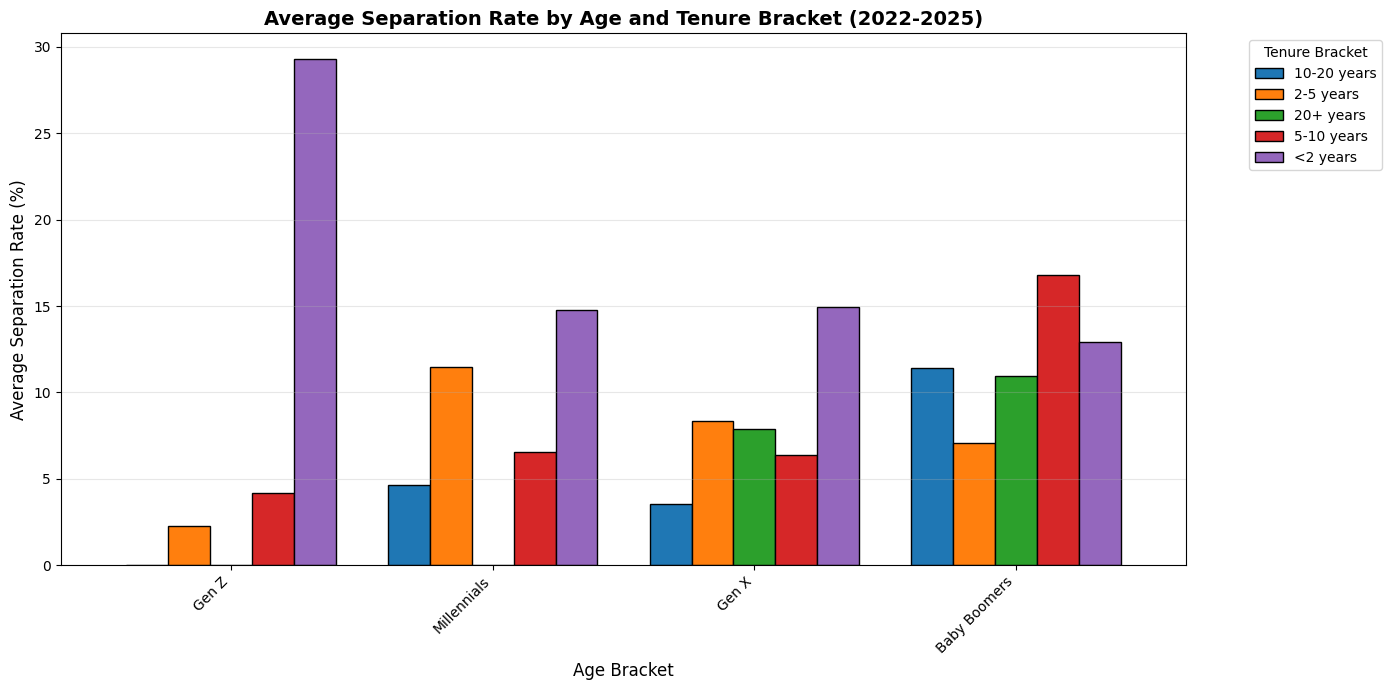

In [122]:
#Grouped Bar Chart - Separation Rate by Age for each Tenure Bracket
plt.figure(figsize=(14, 7))
pivot_grouped = turnover_avg.pivot(index='age_bracket', columns='tenure_bracket', values='avg_separation_rate')
pivot_grouped = pivot_grouped.reindex(index=age_order)

pivot_grouped.plot(kind='bar', figsize=(14, 7), edgecolor='black', width=0.8)
plt.title('Average Separation Rate by Age and Tenure Bracket (2022-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Age Bracket', fontsize=12)
plt.ylabel('Average Separation Rate (%)', fontsize=12)
plt.legend(title='Tenure Bracket', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Assumptions: 2025 Reason for Leave for Age and Tenure

"Leave" Status does not appear in these visualizations because there is no date provided for when the "Leave" staus was taken by employees

In [123]:
#filter to 2025 only and where turnover = 'Yes'
df_2025_separations = output_df[(output_df['year'] == 2025) & (output_df['turnover'] == 'Yes')].copy()

#total separations by reason in 2025
separation_totals_2025 = df_2025_separations.groupby('Status').agg(
    total_separations=('employee_name', 'count')
).reset_index()

separation_totals_2025 = separation_totals_2025.rename(columns={'Status': 'reason_for_separation'})

#percentage column
separation_totals_2025['percentage'] = (
    separation_totals_2025['total_separations'] / separation_totals_2025['total_separations'].sum() * 100
).round(2)

#total row
total_row = pd.DataFrame({
    'reason_for_separation': ['TOTAL'],
    'total_separations': [separation_totals_2025['total_separations'].sum()],
    'percentage': [100.00]
})

separation_totals_2025 = pd.concat([separation_totals_2025, total_row], ignore_index=True)

separation_totals_2025

,reason_for_separation,total_separations,percentage
0,Deceased,3,3.70
1,Resignation,49,60.49
2,Retired,8,9.88
3,Terminated,21,25.93
4,TOTAL,81,100.00


In [124]:
#count separations by age bracket, tenure bracket, and status (reason for separation)

#total employees in each age/tenure bracket for 2025
df_2025_all = output_df[output_df['year'] == 2025].copy()

total_employees_2025 = df_2025_all.groupby(['age_bracket', 'tenure_bracket']).agg(
    total_employees=('employee_name', 'count')
).reset_index()

#count separations by reason
separations_2025 = df_2025_separations.groupby(['age_bracket', 'tenure_bracket', 'Status']).agg(
    count=('employee_name', 'count')
).reset_index()

#rename columns
separations_2025 = separations_2025.rename(columns={
    'Status': 'reason_for_separation',
    'count': 'number_of_separations'
})

#merge with total employees
separations_2025 = separations_2025.merge(
    total_employees_2025,
    on=['age_bracket', 'tenure_bracket'],
    how='left'
)

#calculate separation rate for each reason
separations_2025['separation_rate'] = (
    separations_2025['number_of_separations'] / separations_2025['total_employees'] * 100
).round(2)

#reorder columns
separations_2025 = separations_2025[[
    'age_bracket', 
    'tenure_bracket', 
    'total_employees',
    'reason_for_separation', 
    'number_of_separations',
    'separation_rate'
]]

#display the dataframe
separations_2025

,age_bracket,tenure_bracket,total_employees,reason_for_separation,number_of_separations,separation_rate
0,Baby Boomers,10-20 years,18,Retired,2,11.11
1,Baby Boomers,20+ years,29,Retired,3,10.34
2,Baby Boomers,5-10 years,9,Deceased,1,11.11
3,Baby Boomers,5-10 years,9,Retired,1,11.11
4,Baby Boomers,<2 years,7,Resignation,1,14.29
5,Gen X,10-20 years,80,Deceased,1,1.25
6,Gen X,10-20 years,80,Resignation,5,6.25
7,Gen X,10-20 years,80,Retired,1,1.25
8,Gen X,2-5 years,67,Deceased,1,1.49
9,Gen X,2-5 years,67,Resignation,5,7.46


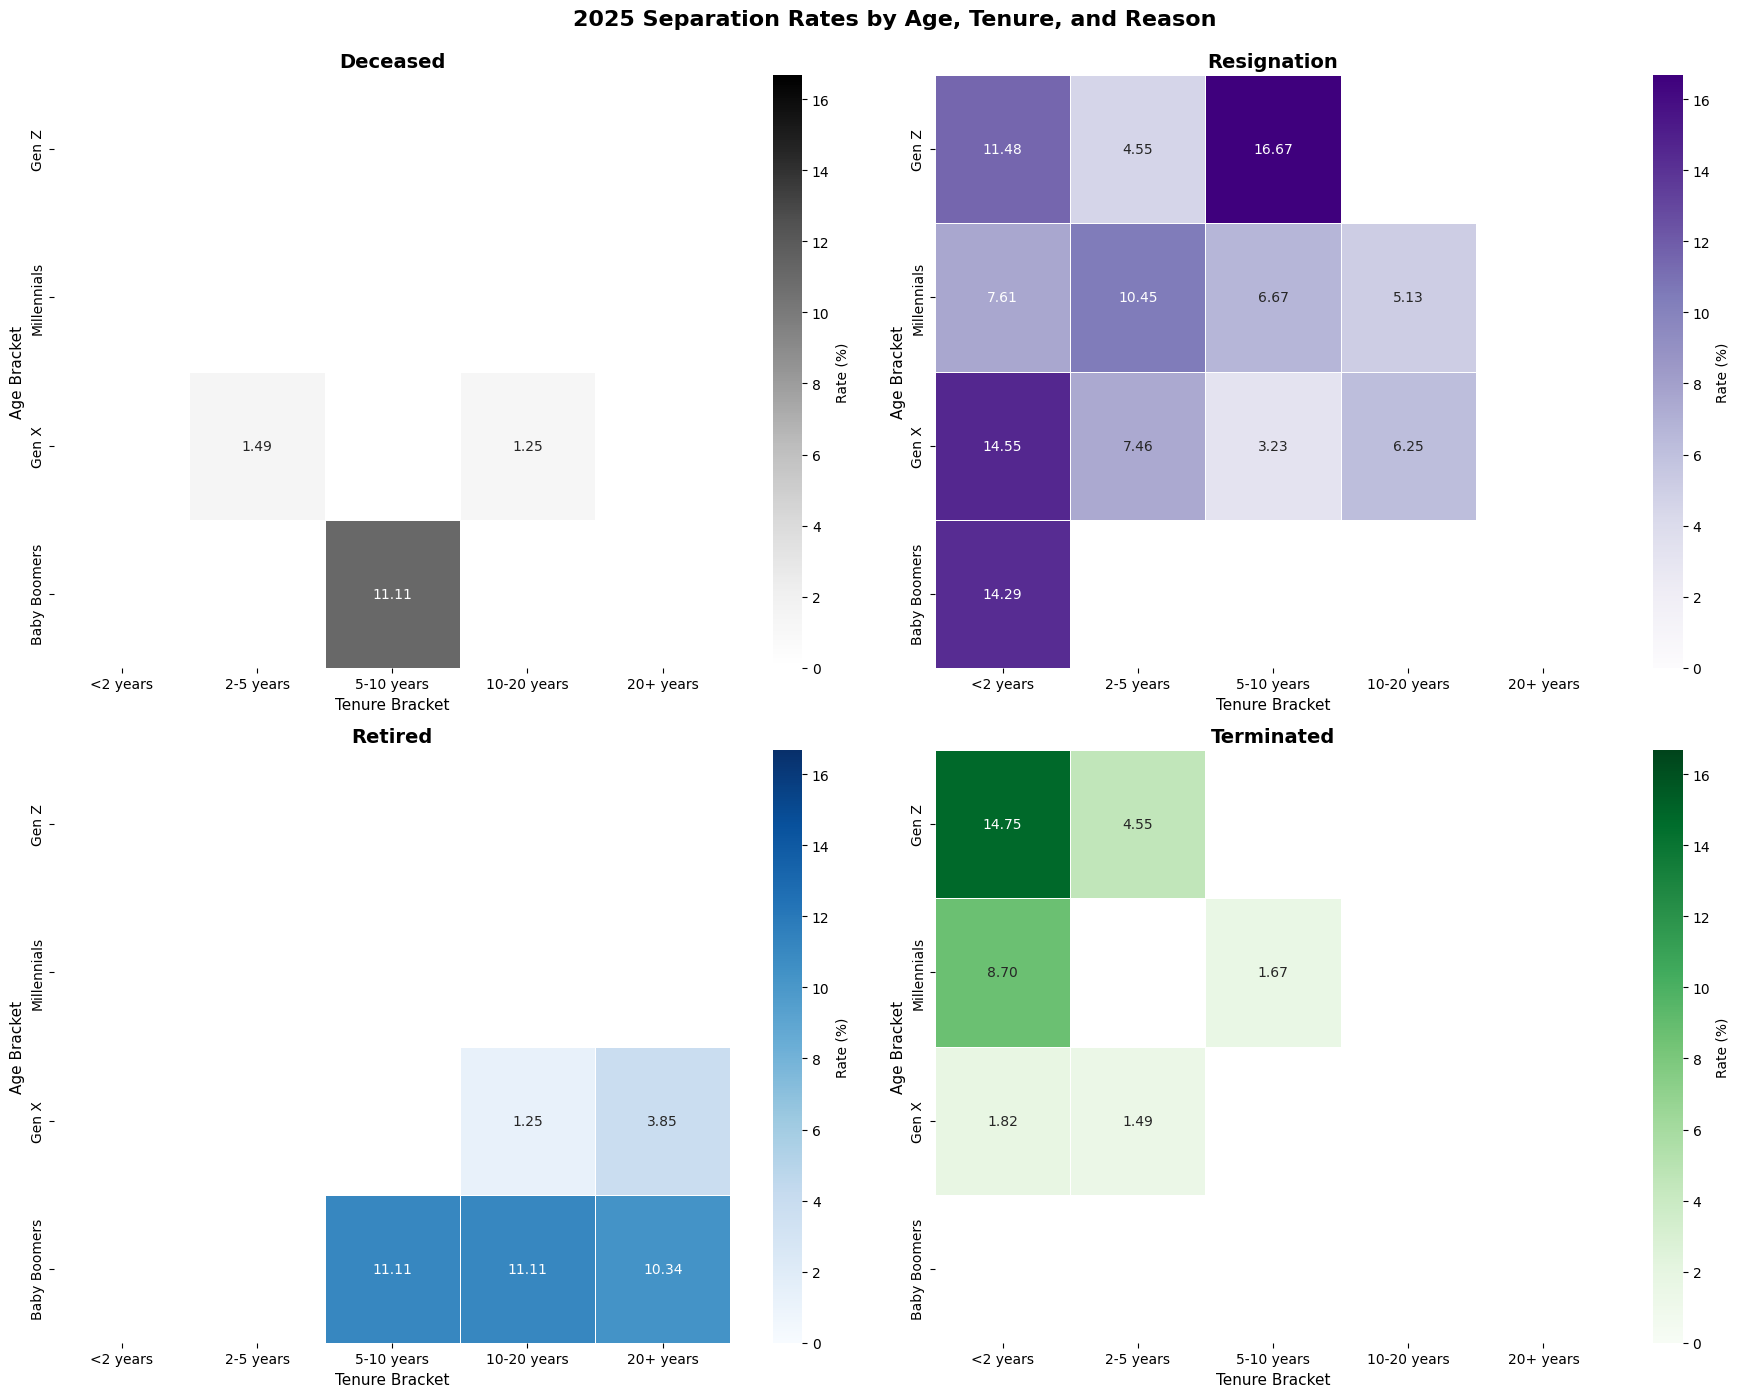

In [130]:
#Combined heatmaps (one heatmap per reason of leave)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('2025 Separation Rates by Age, Tenure, and Reason', fontsize=16, fontweight='bold', y=0.995)

age_order = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']
tenure_order = ['<2 years', '2-5 years', '5-10 years', '10-20 years', '20+ years']
reasons = ['Deceased', 'Resignation', 'Retired', 'Terminated']
cmaps = ['Greys', 'Purples', 'Blues', 'Greens']

for idx, (reason, cmap) in enumerate(zip(reasons, cmaps)):
    ax = axes[idx // 2, idx % 2]
    
    #filter data
    reason_data = separations_2025[separations_2025['reason_for_separation'] == reason].copy()
    
    #pivot
    reason_pivot = reason_data.pivot(
        index='age_bracket',
        columns='tenure_bracket',
        values='separation_rate'
    )
    reason_pivot = reason_pivot.reindex(index=age_order, columns=tenure_order)
    
    #create individual heatmaps
    sns.heatmap(reason_pivot, annot=True, fmt='.2f', cmap=cmap,
                cbar_kws={'label': 'Rate (%)'}, linewidths=0.5,
                ax=ax, vmin=0, vmax=separations_2025['separation_rate'].max())
    
    ax.set_title(f'{reason}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Tenure Bracket', fontsize=11)
    ax.set_ylabel('Age Bracket', fontsize=11)

plt.tight_layout()
plt.show()